# A simple example, solved three ways

1. CVXPY + MOSEK
2. SD ADMM
3. Coordinate descent

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [4]:
from osd import Problem
from osd.components import MeanSquareSmall, SmoothSecondDifference, SparseFirstDiffConvex
from osd.signal_decomp_bcd import run_bcd
from osd.utilities import progress
from osd.signal_decomp_admm import calc_obj

In [5]:
TOL = 1e-5

## Data generation

In [6]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

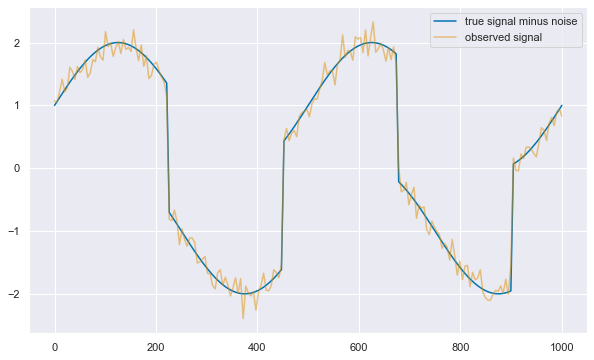

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t, np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# CVXPY

In [49]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = SparseFirstDiffConvex(weight=2e0/T, vmax=1, vmin=-1)
components = [c1, c2, c3]
problem1 = Problem(y, components)

In [56]:
problem1.decompose(how='cvx')

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 26 10:25:53 AM: Your problem has 600 variables, 3 constraints, and 3 parameters.
(CVXPY) Jan 26 10:25:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 26 10:25:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 26 10:25:53 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 26 10:25:53 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 26 10:25:53 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 26 10:25:53 AM: Applying reduction Qp2SymbolicQp

In [57]:
opt_obj_val = problem1.objective_value
opt_obj_val

0.09502286307165887

In [58]:
rms = lambda x: np.sqrt(np.average(np.power(x, 2)))

In [59]:
rms(problem1.estimates[0] - X_real[0])

0.09956172557115156

In [60]:
rms(problem1.estimates[1] - X_real[1])

0.20478786240245134

In [61]:
rms(problem1.estimates[2] - X_real[2])

0.24940340808172567

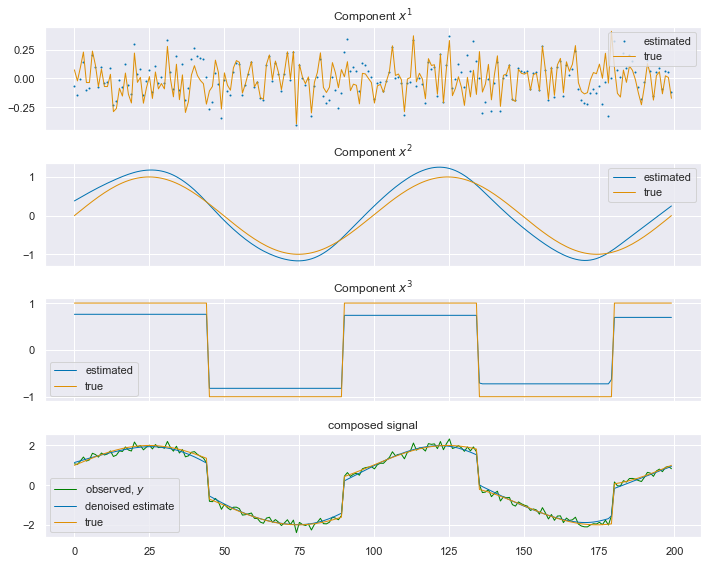

In [25]:
problem1.plot_decomposition(X_real=X_real);

# SD ADMM

In [16]:
problem2 = Problem(y, components)
problem2.decompose(how='admm', verbose=True)
problem2.objective_value

Starting ADMM...
X shape: (3, 200)
u shape: (200,)

[====================] ...245 iterations, 5.67 sec -- obj_val: 9.50e-02, r: 1.02e-05, tol: 1.02e-05      



0.09502387780371878

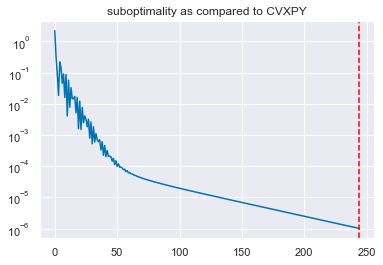

In [13]:
plt.figure()
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val)
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.show()

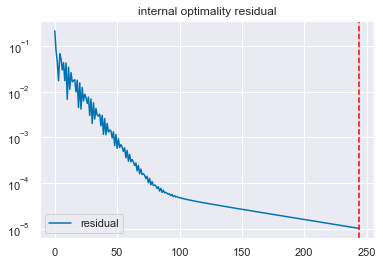

In [13]:
plt.figure()
plt.plot(problem2.admm_result['optimality_residual'], label='residual')
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

In [14]:
problem2.objective_value

0.09502387780371878

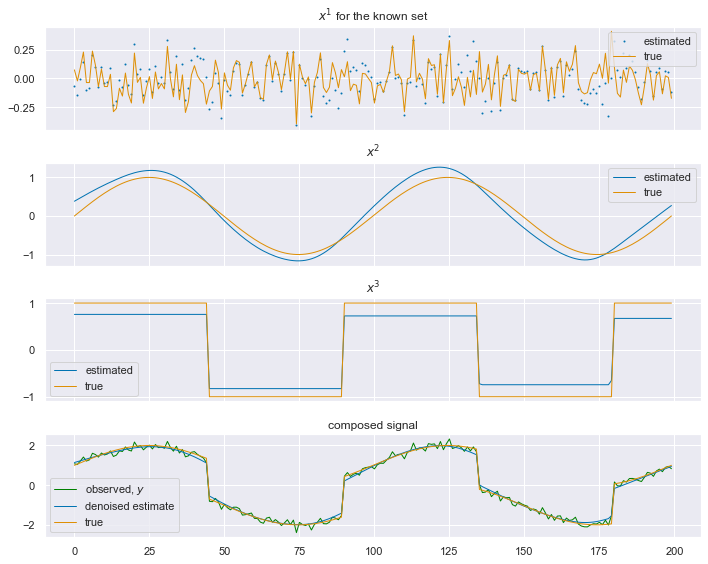

In [15]:
problem2.plot_decomposition(X_real=X_real);

# Coordinate Descent

In [16]:
problem3 = Problem(y, components)
problem3.decompose(how='bcd', stopping_tolerance=TOL)
problem3.objective_value

0.09502335126650452

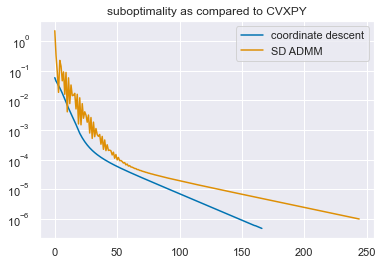

In [17]:
plt.figure()
plt.plot(problem3.bcd_result['obj_vals'] - opt_obj_val, label='coordinate descent')
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val, label='SD ADMM')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.legend()
plt.show()

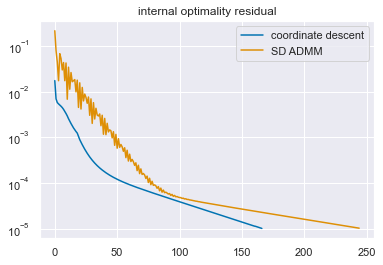

In [18]:
plt.figure()
plt.plot(problem3.bcd_result['optimality_residual'], label='coordinate descent')
plt.plot(problem2.admm_result['optimality_residual'], label='SD ADMM')
plt.yscale('log')
plt.title('internal optimality residual')
plt.legend()
plt.show()

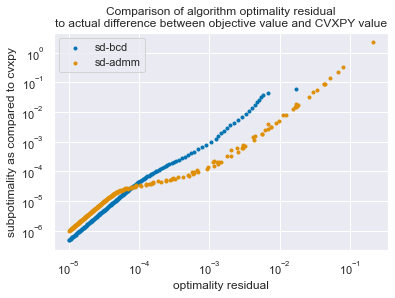

In [19]:
plt.scatter(problem3.bcd_result['optimality_residual'], problem3.bcd_result['obj_vals'] - opt_obj_val, 
            label='sd-bcd', marker='.')
plt.scatter(problem2.admm_result['optimality_residual'], problem2.admm_result['obj_vals'] - opt_obj_val, 
            label='sd-admm', marker='.')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(plt.ylim())
plt.xlabel('optimality residual')
plt.ylabel('subpotimality as compared to cvxpy')
# plt.gca().set_aspect('equal')
plt.legend()
plt.title('Comparison of algorithm optimality residual\nto actual difference between objective value and CVXPY value');

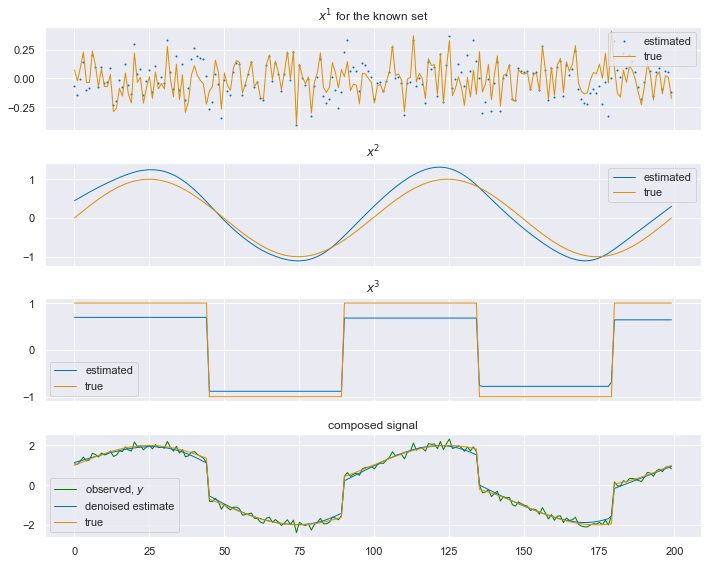

In [20]:
problem3.plot_decomposition(X_real=X_real);

### CHECK THIS 1/10/22

- The dual variable is ??? times the first component
- The ADMM dual state variable converges to $???/\rho$ times the SD consistency dual variable

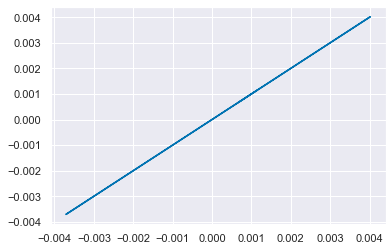

In [21]:
plt.figure()
plt.plot(problem1.problem.variables()[0].value * (-2 / T),
         problem1.problem.constraints[-1].dual_value)

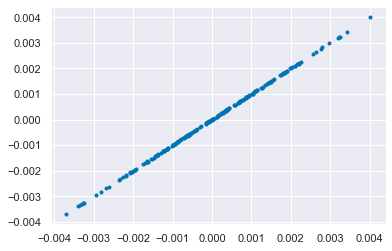

In [22]:

plt.figure()
plt.plot(problem2.admm_result['u'] * (4/T),
         problem1.problem.constraints[-1].dual_value,
        marker='.', ls='none')

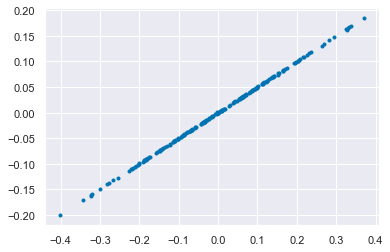

In [23]:
plt.figure()
plt.plot(problem1.problem.variables()[0].value,
         (-1) * problem2.admm_result['u'], marker='.', ls='none');